In [1]:
#Imports
import numpy as np
from os import listdir
from os.path import isfile, join
import tifffile
from cellpose import models, io, core
import matplotlib.pyplot as plt
import math
from u_net import UNet
import torch
from scipy import ndimage
from statistics import mean, median
import seaborn as sns


c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_files(path,normalise=False,remove_txt=False):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    if remove_txt:
        onlyfiles = [val for val in onlyfiles if not val.endswith(".txt")]

    onlyfiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #if num_imgs > len(onlyfiles): num_imgs = len(onlyfiles)
    files = [np.squeeze(tifffile.imread(path +  onlyfiles[i])) for i in range(len(onlyfiles))]
    
    if normalise:
        files = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in files]
    
    return files
    
def get_data(path, set='01',normalise_images=True):

    if len(set) == 2: #set 01 or set 02
        images_path = path + set + '/'
        images = get_files(images_path,normalise=normalise_images)
        masks_path = path + set + '_GT/TRA/'
        masks = get_files(masks_path,remove_txt=True)
    elif set == '0102': #both sets
        images_path = path + '01/'
        images_01 = get_files(images_path,normalise=normalise_images)
        images_path = path + '02/'
        images_02 = get_files(images_path,normalise=normalise_images)
        images = images_01 + images_02

        masks_path = path + '01_GT/TRA/'
        masks_01 = get_files(masks_path,remove_txt=True)
        masks_path = path + '02_GT/TRA/'
        masks_02 = get_files(masks_path,remove_txt=True)
        masks = masks_01 + masks_02
    else:
        images = []
        masks = []

    return images, masks

In [6]:
import os
print(os.getcwd())

c:\Users\rz200\Documents\development\distillCellSegTrack\matching


In [3]:
#Get cell images #Get cell masks
images, masks = get_data('\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-N2DH-GOWT1\\', set='01', normalise_images=False)

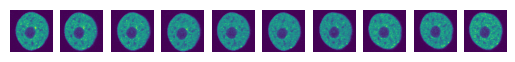

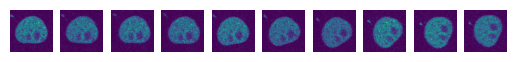

C:\Users\rz200\AppData\Local\Temp\ipykernel_25404\2488949382.py:18: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(crop)


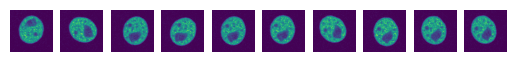

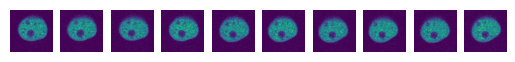

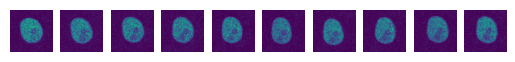

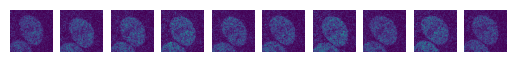

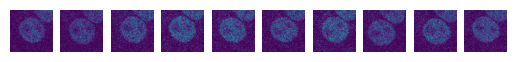

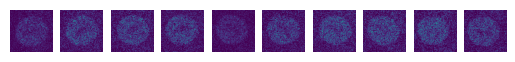

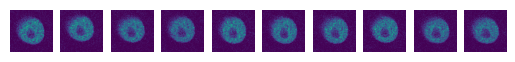

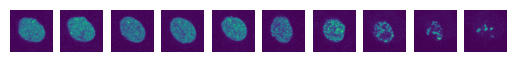

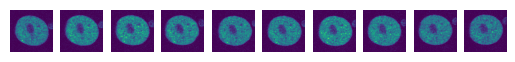

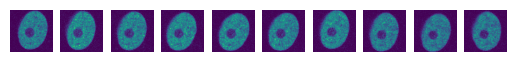

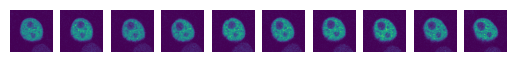

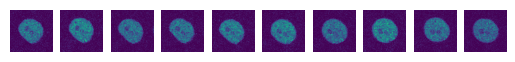

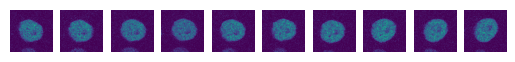

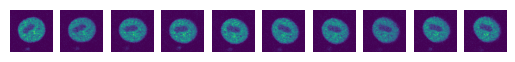

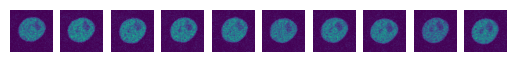

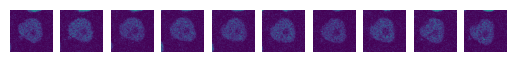

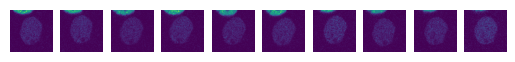

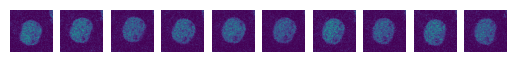

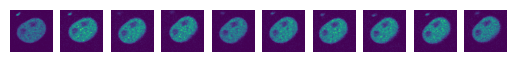

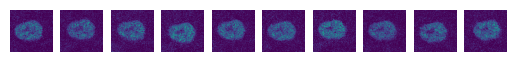

In [8]:
#Plotting matching indices
crop_size = 100

for j in np.unique(masks[0])[1:]:
    for i in range(10):
        plt.subplot(1,10,i+1)
        x, y = np.where(masks[i]==j)
        x = np.mean(x)
        y = np.mean(y)
        if math.isnan(x) or math.isnan(y):
            #crop is empty image of zeros
            crop = np.zeros((crop_size,crop_size))
            plt.xticks([])
            plt.yticks([])
        else:
            crop = images[i][int(x-crop_size/2):int(x+crop_size/2),int(y-crop_size/2):int(y+crop_size/2)]
            plt.axis('off')
        plt.imshow(crop)
    plt.show()

In [5]:
def block_mean(ar, fact, method):
    assert isinstance(fact, int), type(fact)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    regions = sy//fact * (X//fact) + Y//fact
    #res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
    if method == 'maximum':
        res = ndimage.maximum(ar, labels=regions, index=np.arange(regions.max() + 1))
    elif method == 'minimum':
        res = ndimage.minimum(ar, labels=regions, index=np.arange(regions.max() + 1))
    elif method == 'median':
        res = ndimage.minimum(ar, labels=regions, index=np.arange(regions.max() + 1))
    res.shape = (sx//fact, sy//fact)
    return res

In [6]:
def get_cell_encodings(encoder,image,mask,downsampling_method='maximum',device=None):
    #Get encoding of image
    image = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0)
    if device is not None:
        image = image.to(device)
    encoding = encoder(image)[2].cpu().detach().numpy()[0]

    #Downsample the mask to match the shape of the encoding
    downsampled_mask = block_mean(mask, 4, method=downsampling_method)

    #Mask out the encoder features of each cell
    encodings_cells_per_channel = []
    for j in np.unique(downsampled_mask)[1:]: #64 channels
        encodings_of_cell = []
        for channel_number in range(encoding.shape[0]):
            encodings_of_cell.append(encoding[channel_number][np.where(downsampled_mask==j)])
        encodings_cells_per_channel.append(encodings_of_cell)

    return encodings_cells_per_channel

In [8]:
def get_cell_centers(mask):
    centers = []
    for j in np.unique(mask)[1:]:
        x, y = np.where(mask==j)
        x = np.mean(x)
        y = np.mean(y)
        centers.append((x,y))
    return centers

def get_cell_distances(centers_0,centers_1):
    distances = []
    for center_0 in centers_0:
        distances.append([np.sqrt((center_0[0]-center_1[0])**2 + (center_0[1]-center_1[1])**2) for center_1 in centers_1])
    return distances

In [9]:
def get_cell_centers(mask):
    centers = []
    for j in np.unique(mask)[1:]:
        x, y = np.where(mask==j)
        x = np.mean(x)
        y = np.mean(y)
        centers.append((x,y))
    return centers

def get_cell_distances(centers_0,centers_1):
    distances = []
    for center_0 in centers_0:
        distances.append([np.sqrt((center_0[0]-center_1[0])**2 + (center_0[1]-center_1[1])**2) for center_1 in centers_1])
    return distances

In [31]:
#calculate difference in cell sizes to define a size coefficient (1/difference_in_cell_sizes)

#for i in np.unique(masks[0])[1:]:
lenghts_of_cells_0 = np.unique(masks[0],return_counts=True)[1][1:]
lengths_of_cells_1 = np.unique(masks[1],return_counts=True)[1][1:]
#get the difference between every values
size_difference = []
for i in lenghts_of_cells_0:
    size_differences_per_cell = []
    for j in lengths_of_cells_1:
        size_differences_per_cell.append(abs(i-j))
    size_difference.append(size_differences_per_cell)

print(size_difference)

[[148, 1645, 2321, 2348, 2613, 2613, 2749, 2122, 2568, 2321, 2473, 1813, 1069, 2749, 2893, 2893, 2321, 2473, 3017, 2915, 2951, 2316, 3032], [1497, 0, 676, 703, 968, 968, 1104, 477, 923, 676, 828, 168, 576, 1104, 1248, 1248, 676, 828, 1372, 1270, 1306, 671, 1387], [2173, 676, 0, 27, 292, 292, 428, 199, 247, 0, 152, 508, 1252, 428, 572, 572, 0, 152, 696, 594, 630, 5, 711], [2325, 828, 152, 125, 140, 140, 276, 351, 95, 152, 0, 660, 1404, 276, 420, 420, 152, 0, 544, 442, 478, 157, 559], [2465, 968, 292, 265, 0, 0, 136, 491, 45, 292, 140, 800, 1544, 136, 280, 280, 292, 140, 404, 302, 338, 297, 419], [2465, 968, 292, 265, 0, 0, 136, 491, 45, 292, 140, 800, 1544, 136, 280, 280, 292, 140, 404, 302, 338, 297, 419], [2013, 516, 160, 187, 452, 452, 588, 39, 407, 160, 312, 348, 1092, 588, 732, 732, 160, 312, 856, 754, 790, 155, 871], [1822, 325, 351, 378, 643, 643, 779, 152, 598, 351, 503, 157, 901, 779, 923, 923, 351, 503, 1047, 945, 981, 346, 1062], [2989, 1492, 816, 789, 524, 524, 388, 1015, 56

In [10]:
from scipy import spatial

def calculate_cosine_distance(a, b):
    cosine_distance = float(spatial.distance.cosine(a, b))
    return cosine_distance

def calculate_cosine_similarity(a, b):
    cosine_similarity = 1 - calculate_cosine_distance(a, b)
    return cosine_similarity

def calculate_angular_distance(a, b):
    cosine_similarity = calculate_cosine_similarity(a, b)
    angular_distance = math.acos(cosine_similarity) / math.pi
    return angular_distance

In [71]:
#for now just get the cos_sim between two of them
def get_cos_sims_between_images(encodings_cells_per_channel_0,encodings_cells_per_channel_1, cell_distances, padding_method='mean'):
    cosine_similarities_between_images = []

    for k in range(len(encodings_cells_per_channel_0)):

        cosine_similarities_per_cell = []

        for j in range(len(encodings_cells_per_channel_1)):
            cosine_similarities = []
            #if distances[k][j] > 1000:
            #    cosine_similarities_per_cell.append(0)
            #    continue
            #else:
            for i in range(64):
                arr1 = encodings_cells_per_channel_0[k][i]
                arr2 = encodings_cells_per_channel_1[j][i]

                if len(arr1) > len(arr2):
                    arr2 = np.pad(arr2, (0, arr1.shape[0]-arr2.shape[0]), padding_method)
                elif len(arr1) < len(arr2):
                    arr1 = np.pad(arr1, (0, arr2.shape[0]-arr1.shape[0]), padding_method)

                cos_sim = np.dot(arr1, arr2) / (np.linalg.norm(arr1) * np.linalg.norm(arr2))
                #cos_sim = 1 - calculate_angular_distance(arr1, arr2)
                cosine_similarities.append(cos_sim)

            mean_cosine_similarity = mean(cosine_similarities)
            distance_coeff = 1/(cell_distances[k][j]) if cell_distances[k][j] != 0 else 1
            #size_coeff = 1/(size_difference[k][j])
            similarity_coeff = mean_cosine_similarity + distance_coeff*0.8
            cosine_similarities_per_cell.append(similarity_coeff)

        cosine_similarities_between_images.append(cosine_similarities_per_cell)
    
    cosine_similarities_between_images = np.array(cosine_similarities_between_images)

    return cosine_similarities_between_images

In [69]:
#calculate accuracy by the percentage of pairs that have the same value for both elements

def get_pairs(cosine_similarities_between_images_mean):
    pairs = []
    length = min(len(cosine_similarities_between_images_mean),len(cosine_similarities_between_images_mean[0]))
    cos_sims_lst = np.array(cosine_similarities_between_images_mean)
    for i in range(length):
        max_index = np.argmax(cos_sims_lst)
        row, col = np.unravel_index(max_index, cos_sims_lst.shape)
        if row not in [pair[0] for pair in pairs] and col not in [pair[1] for pair in pairs]: #to not get duplicate pairs
            pairs.append((row,col))
        cos_sims_lst[:,col] = -10
        cos_sims_lst[row,:] = -10
    return pairs

def get_accuracy(pairs):
    correct_pairs = 0
    for pair in pairs:
        if pair[0] == pair[1]:
            correct_pairs += 1
    accuracy = correct_pairs/len(pairs)
    return accuracy

In [25]:
#Import distill model
model = UNet()
model = model.to('cuda:0')
#model.load_state_dict(torch.load('/Users/rehanzuberi/Downloads/distillCellSegTrack/segmentation/train_dir/models/distillation_model_GOWT1_3',map_location=torch.device('cpu')))
model.load_state_dict(torch.load('/Users/rz200/Documents/development/distillCellSegTrack/segmentation/train_dir/models/distillation_model_GOWT1_3'))

#Get encoder
encoder = model.encoder
downsampling_method = 'maximum'

In [33]:
def get_cell_pairs_between_two_images(image_0,mask_0,image_1,mask_1,encoder):
    #get centers of cells
    centers_0 = get_cell_centers(mask_0)
    centers_1 = get_cell_centers(mask_1)
    #get distances between cells
    distances = get_cell_distances(centers_0,centers_1)
    #get encodings of cells
    encodings_cells_0 = get_cell_encodings(encoder,image_0,mask_0,downsampling_method,device='cuda:0')
    encodings_cells_1 = get_cell_encodings(encoder,image_1,mask_1,downsampling_method,device='cuda:0')
    #get cosine similarities between cells
    cosine_similarities_between_images_mean = get_cos_sims_between_images(encodings_cells_0,encodings_cells_1, distances)
    #get mean cosine similarity between cells
    #cosine_similarities_between_images_mean = np.mean(cosine_similarities_between_images,axis=0)
    #get pairs
    pairs = get_pairs(cosine_similarities_between_images_mean)
    #get accuracy
    accuracy = get_accuracy(pairs)
    return accuracy

In [73]:
#Get accuracy between two images
accuracies = []
for i in range(30):
    accuracy = get_cell_pairs_between_two_images(images[i],masks[i],images[i+1],masks[i+1],encoder)
    accuracies.append(accuracy)
print(accuracies)
print(mean(accuracies))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9130434782608695, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.43478260869565216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
0.9782608695652174


In [58]:
images, masks = get_data('\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-N2DH-GOWT1\\', set='01', normalise_images=False)


In [45]:
accuracy = get_cell_pairs_between_two_images(images[21],masks[21],images[22],masks[22],encoder)

print(accuracy)

1.0


In [76]:
#Get accuracy between two images
#Get cell images #Get cell masks
images, masks = get_data('\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-N2DH-GOWT1\\', set='01', normalise_images=False)
accuracies_01 = []
for i in range(len(images)-1):
    accuracy = get_cell_pairs_between_two_images(images[i],masks[i],images[i+1],masks[i+1],encoder)
    accuracies_01.append(accuracy)
print(accuracies_01)
print(mean(accuracies_01))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9130434782608695, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.43478260869565216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.375, 0.2916666666666667, 0.8333333333333334, 0.2608695652173913, 1.0, 0.2857142857142857, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9047619047619048, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.45, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95]
0.952738152117034


In [77]:
print(median(accuracies_01))

1.0


In [78]:
#Get accuracy between two images
#Get cell images #Get cell masks
images, masks = get_data('\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-N2DH-GOWT1\\', set='02', normalise_images=False)
accuracies_02 = []
for i in range(len(images)-1):
    accuracy = get_cell_pairs_between_two_images(images[i],masks[i],images[i+1],masks[i+1],encoder)
    accuracies_02.append(accuracy)
print(accuracies_02)
print(mean(accuracies_02))

[1.0, 0.92, 0.875, 0.9166666666666666, 1.0, 0.8333333333333334, 0.875, 0.8695652173913043, 1.0, 0.8695652173913043, 0.8695652173913043, 1.0, 0.5909090909090909, 1.0, 1.0, 0.7272727272727273, 0.9090909090909091, 0.8333333333333334, 0.875, 0.92, 0.8333333333333334, 0.875, 1.0, 0.9130434782608695, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.16, 0.92, 0.36, 1.0, 1.0, 0.8148148148148148, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.03571428571428571, 0.0, 0.8666666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.36666666666666664, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.36666666666666664, 1.0, 1.0, 1.0, 1.0, 0.3448275862068966, 1.0, 0.3793103448275862, 0.36666666666666664, 0.10344827586206896, 0.5862068965517241, 1.0, 0.8620689655172413, 0.9333333333333333, 0.5172413793103449, 0.8928571428571429, 1.0]
0.8283754749014977


In [79]:
print(median(accuracies_02))

1.0


In [80]:
accuracies_0102 = accuracies_01+accuracies_02
print(mean(accuracies_0102))
print(median(accuracies_0102))

0.8905568135092659
1.0


In [86]:
print(max(accuracies_0102))

1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


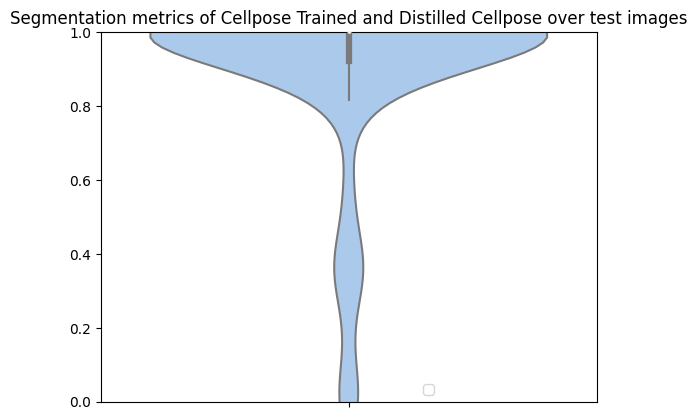

In [88]:
plt.title('Segmentation metrics of Cellpose Trained and Distilled Cellpose over test images')
sns.violinplot(y=accuracies_0102, palette="pastel")
#plt.legend(loc=(1.05, 0.876))
plt.ylim(0,1)
plt.legend(loc=(0.65, 0.0176))

C:\Users\rz200\AppData\Local\Temp\ipykernel_18328\248515289.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(x=accuracies_0102, palette="pastel")


([<matplotlib.axis.YTick at 0x20304427940>,
 [Text(0, 0, '0'),
  Text(0, 20, '20'),
  Text(0, 40, '40'),
  Text(0, 60, '60'),
  Text(0, 80, '80'),
  Text(0, 100, '100'),
  Text(0, 120, '120'),
  Text(0, 140, '140')])

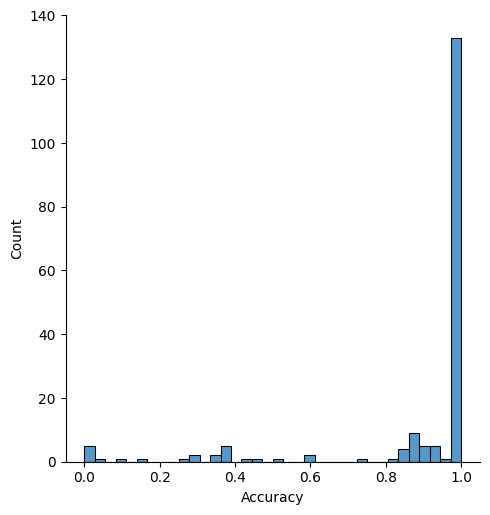

In [108]:
#plt.title('Segmentation metrics of Cellpose Trained and Distilled Cellpose over test images')
sns.displot(x=accuracies_0102, palette="pastel")
plt.xlabel('Accuracy')
plt.yticks([i for i in range(0,147,20)])
#plt.legend(loc=(1.05, 0.876))
##plt.ylim(0,1)
#plt.legend(loc=(0.65, 0.0176))

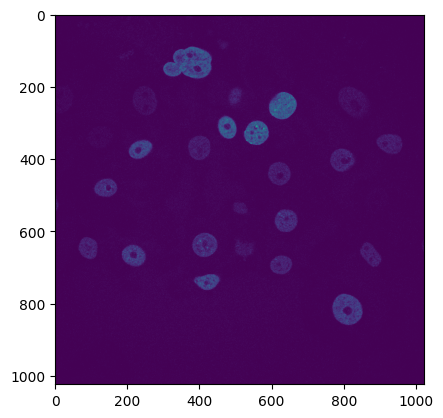

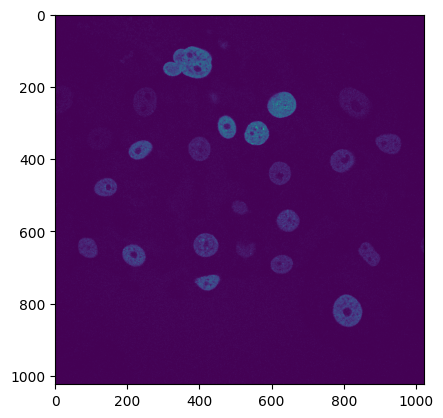

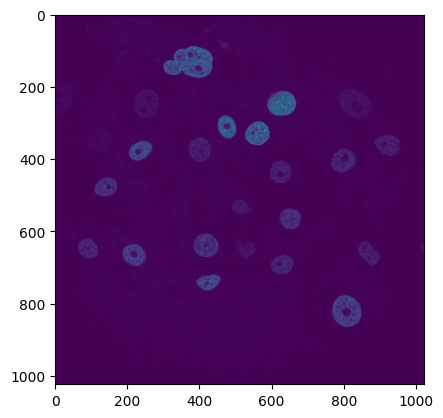

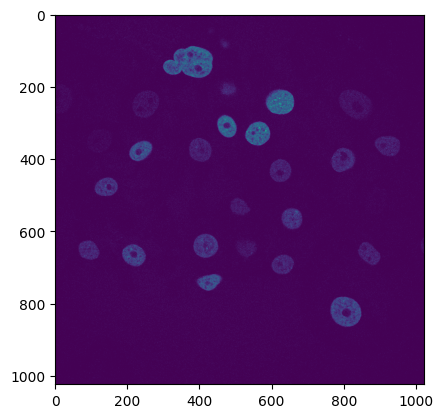

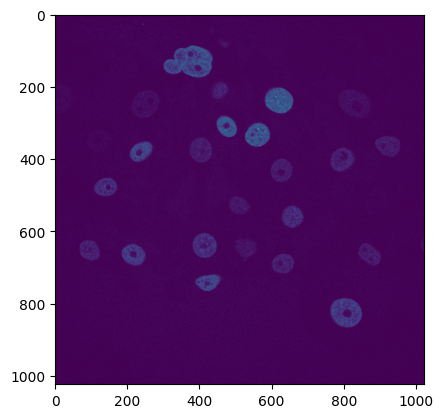

In [54]:
plt.imshow(images[19]);plt.show()
plt.imshow(images[20]);plt.show()

plt.imshow(images[21]);plt.show()
plt.imshow(images[22]);plt.show()
plt.imshow(images[23]);plt.show()


In [15]:


#Get encoder features
test_image_0 = images[0]
test_mask_0 = masks[0]
encodings_cells_per_channel_0 = get_cell_encodings(encoder,test_image_0,test_mask_0,downsampling_method=downsampling_method,device='cuda:0')

test_image_1 = images[1]
test_mask_1 = masks[1]
encodings_cells_per_channel_1 = get_cell_encodings(encoder,test_image_1,test_mask_1,downsampling_method=downsampling_method,device='cuda:0')

In [20]:
cell_centers_0 = get_cell_centers(test_mask_0)
cell_centers_1 = get_cell_centers(test_mask_1)
cell_distances = get_cell_distances(cell_centers_0,cell_centers_1)

cosine_similarities_between_images_mean = get_cos_sims_between_images(encodings_cells_per_channel_0,encodings_cells_per_channel_1,cell_distances,padding_method='mean')

In [24]:
pairs = get_pairs(cosine_similarities_between_images_mean)
accuracy = get_accuracy(pairs)
print(accuracy)

1.0


In [66]:
#get centers of cells

index = 20
index_1 = index+1

mask_0 = masks[index]
mask_1 = masks[index_1]

image_0 = images[index]
image_1 = images[index_1]


centers_0 = get_cell_centers(mask_0)
centers_1 = get_cell_centers(mask_1)
#get distances between cells
distances = get_cell_distances(centers_0,centers_1)
#get encodings of cells
encodings_cells_0 = get_cell_encodings(encoder,image_0,mask_0,downsampling_method,device='cuda:0')
encodings_cells_1 = get_cell_encodings(encoder,image_1,mask_1,downsampling_method,device='cuda:0')
#get cosine similarities between cells
cosine_similarities_between_images_mean = get_cos_sims_between_images(encodings_cells_0,encodings_cells_1, distances)
#get mean cosine similarity between cells
#cosine_similarities_between_images_mean = np.mean(cosine_similarities_between_images,axis=0)
#get pairs
pairs = get_pairs(cosine_similarities_between_images_mean)
accuracy = get_accuracy(pairs)
print(accuracy)

0.43478260869565216


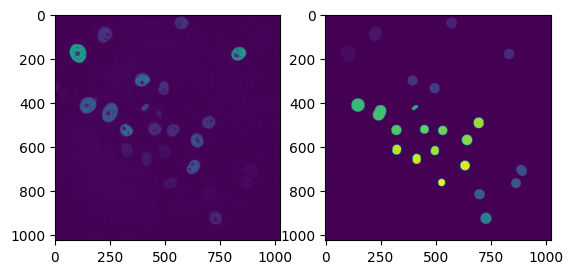

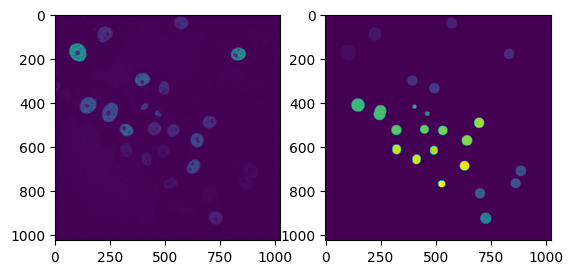

In [63]:
plt.subplot(1,2,1)
plt.imshow(image_0)
plt.subplot(1,2,2)
plt.imshow(mask_0)
plt.show()

plt.subplot(1,2,1)
plt.imshow(image_1)
plt.subplot(1,2,2)
plt.imshow(mask_1)
plt.show()

In [64]:
print(pairs)

[(15, 16), (4, 4), (5, 5), (11, 12), (14, 15), (2, 2), (13, 14), (3, 3), (9, 9), (7, 7), (19, 20), (12, 13), (20, 21), (17, 18), (21, 22), (1, 1), (8, 8), (6, 6), (16, 17), (18, 19), (0, 0), (22, 23), (10, 11)]


In [47]:
print(len(cosine_similarities_between_images_mean),len(cosine_similarities_between_images_mean[0]))

23 23


In [48]:
print(len(np.unique(masks[0])[1:]))

23


In [49]:
print(len(pairs))
print(correct_pairs)

23
23


In [50]:
for pair in pairs:
    if pair[0] != pair[1]:
        print(pair)

In [461]:
print(np.unique(masks[0],return_counts=True)[1][26])
print(np.unique(masks[1],return_counts=True)[1][26])

print(np.unique(masks[0],return_counts=True)[1][36])
print(np.unique(masks[1],return_counts=True)[1][36])


249
249
145
145


In [ ]:
arr1 = encodings_cells_per_channel_0[0][26]
arr2 = encodings_cells_per_channel_1[1][i]

if len(arr1) > len(arr2):
    arr2 = np.pad(arr2, (0, arr1.shape[0]-arr2.shape[0]), padding_method)
elif len(arr1) < len(arr2):
    arr1 = np.pad(arr1, (0, arr2.shape[0]-arr1.shape[0]), padding_method)

cos_sim = np.dot(arr1, arr2) / (np.linalg.norm(arr1) * np.linalg.norm(arr2))

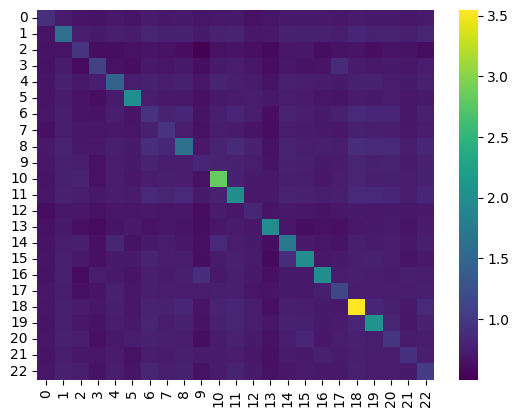

In [51]:
sns.heatmap(cosine_similarities_between_images_mean, cmap='viridis'); plt.show()

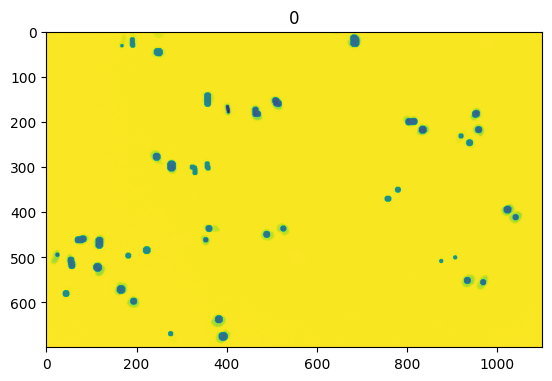

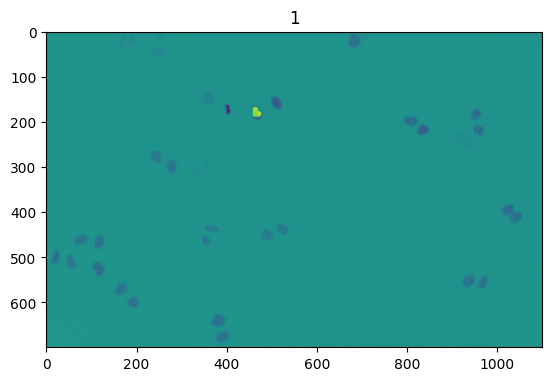

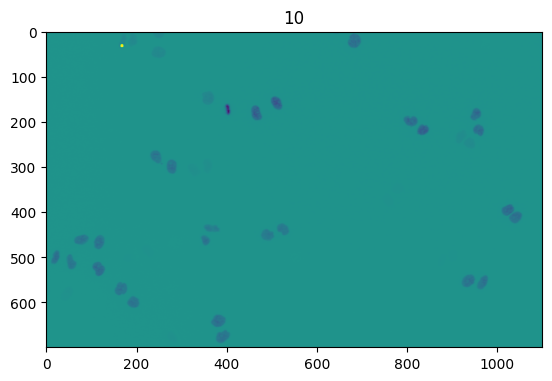

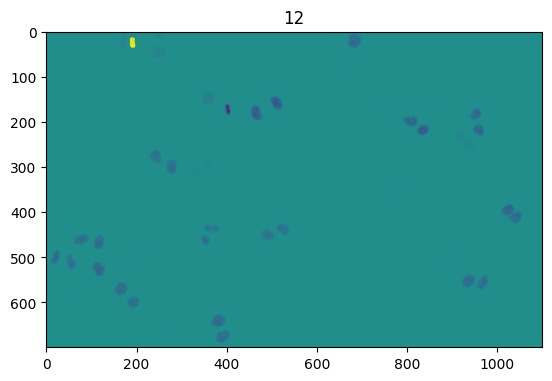

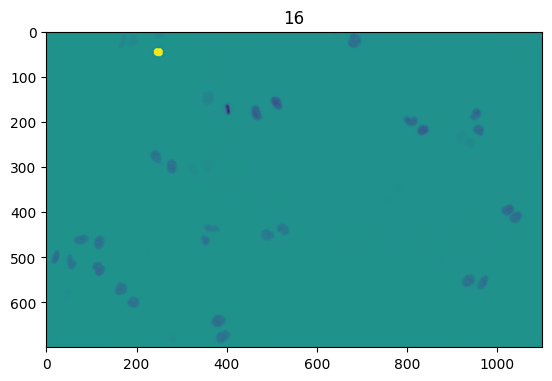

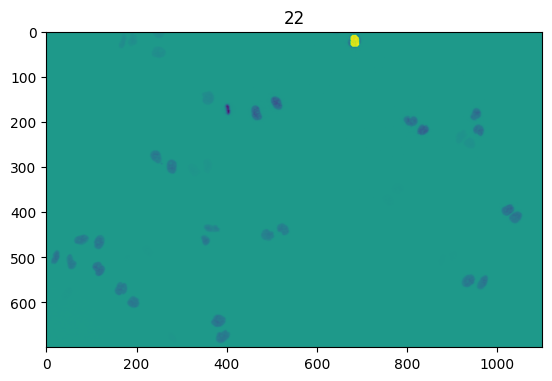

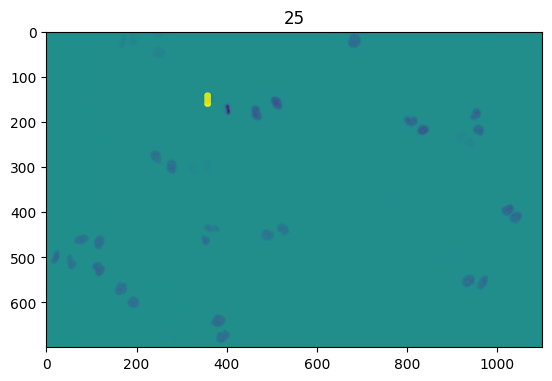

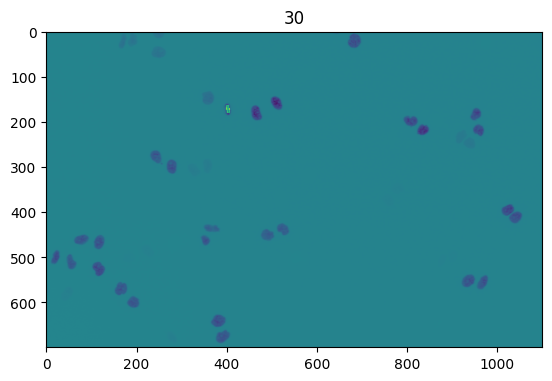

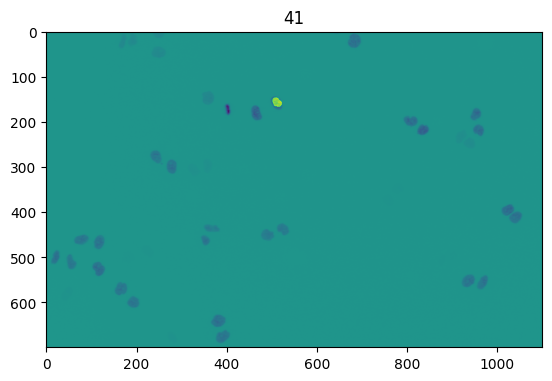

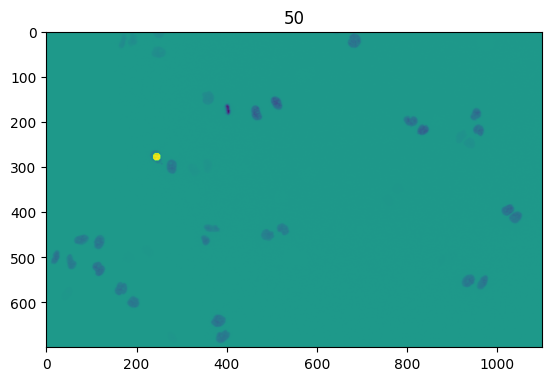

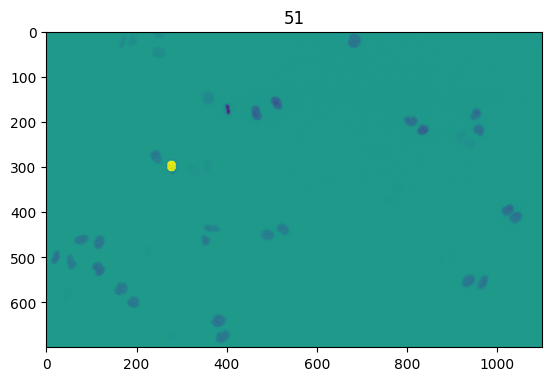

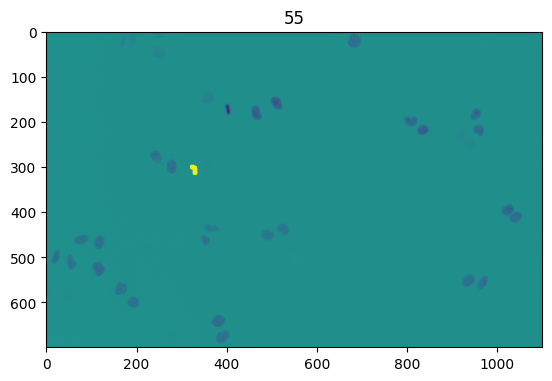

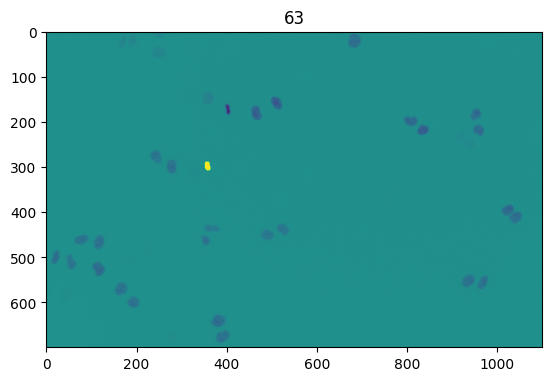

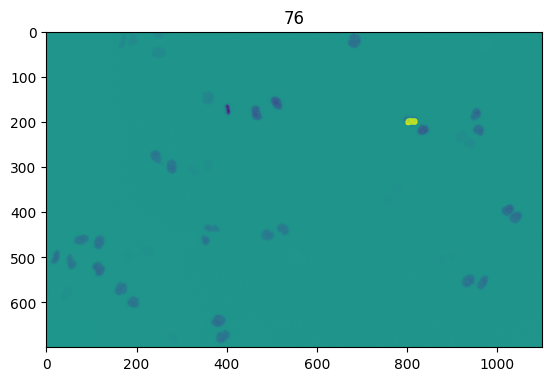

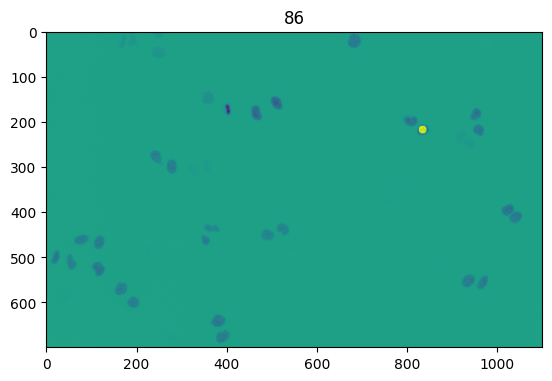

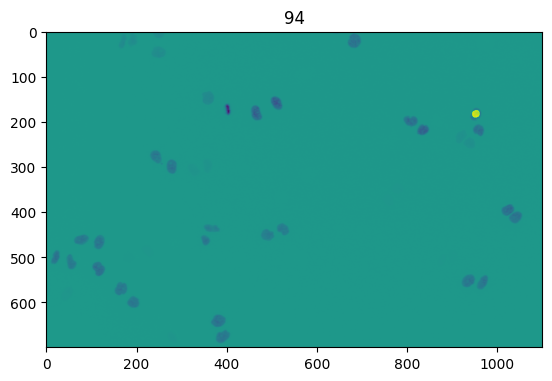

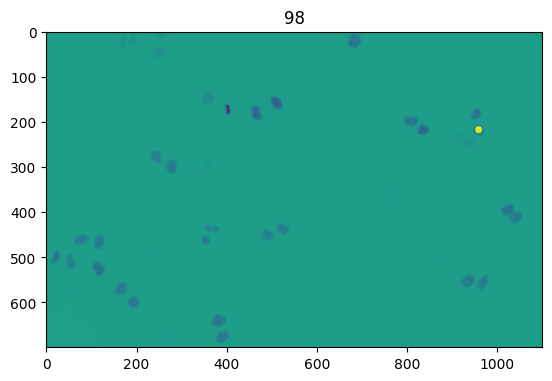

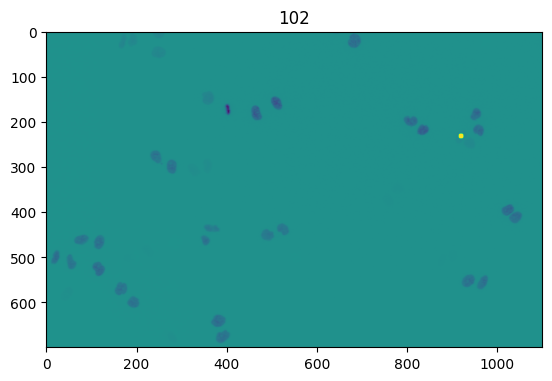

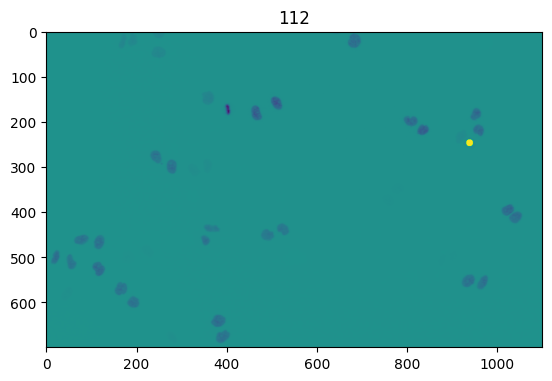

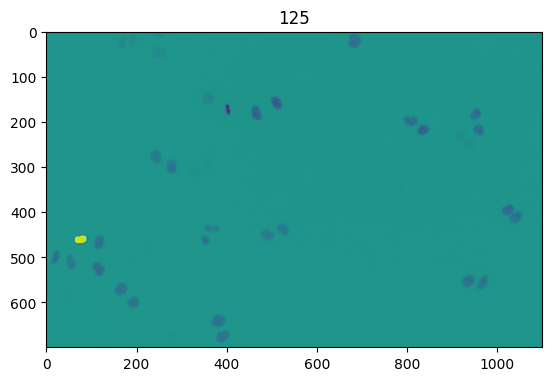

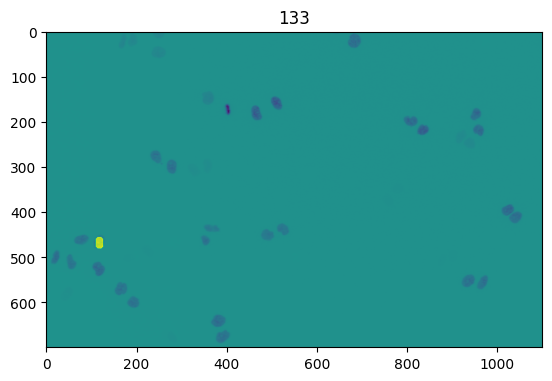

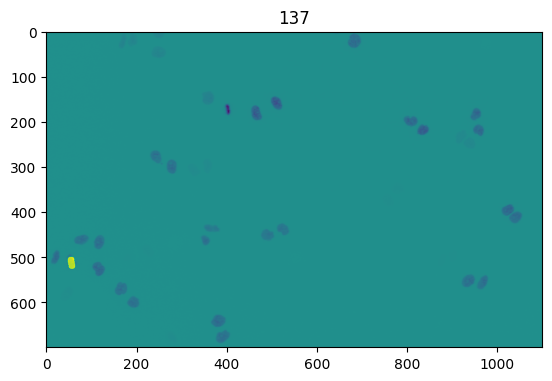

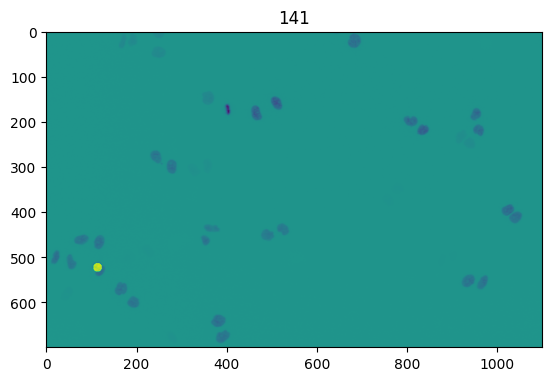

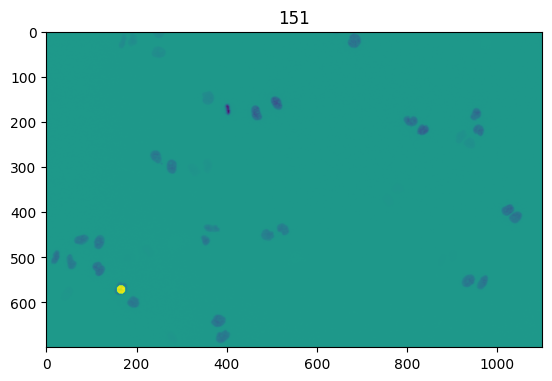

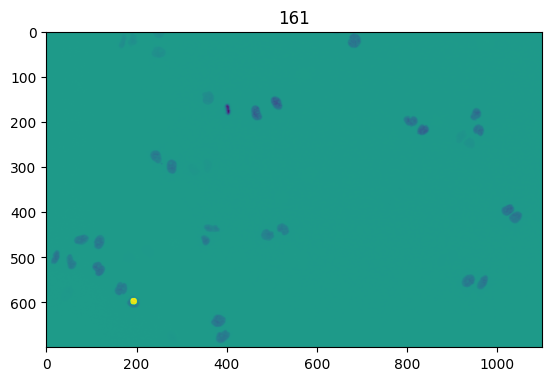

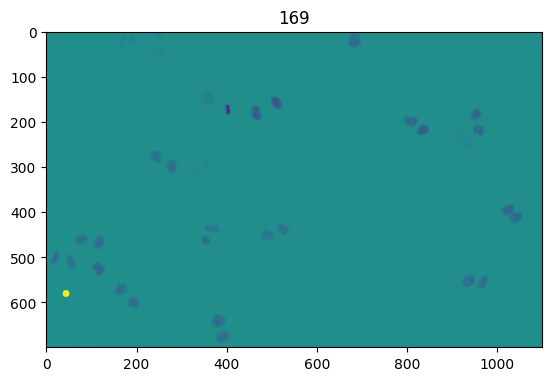

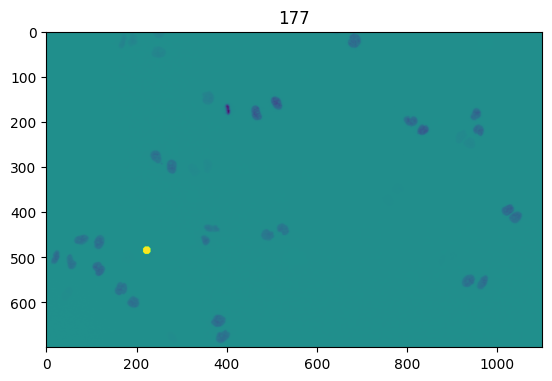

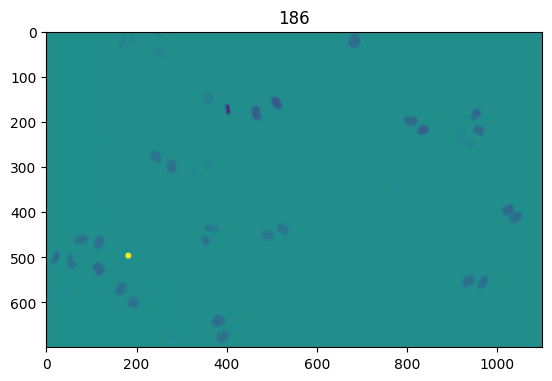

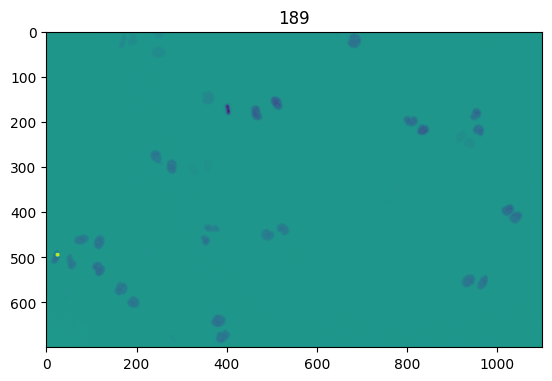

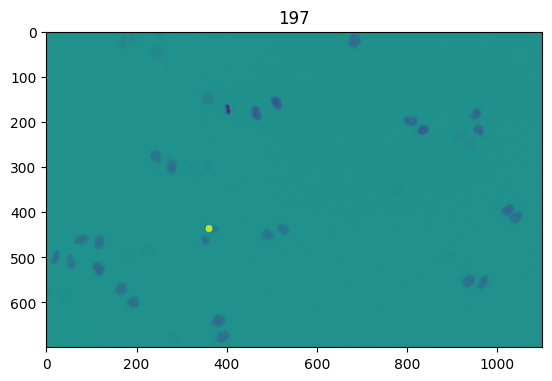

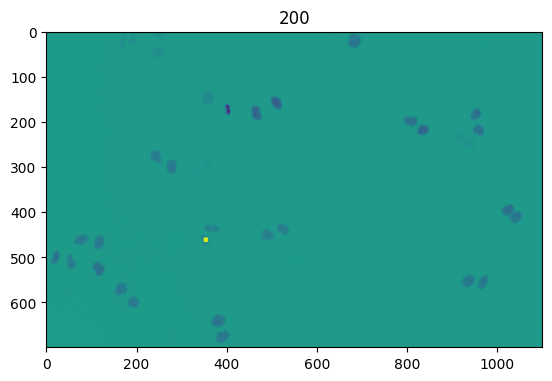

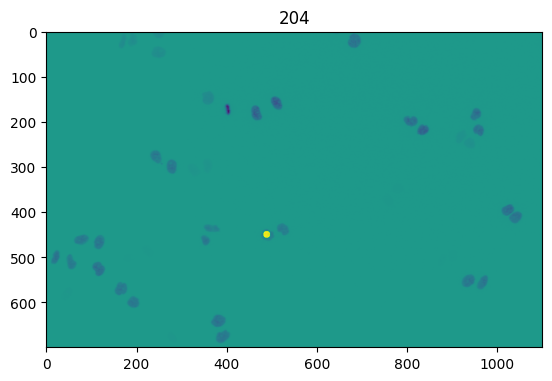

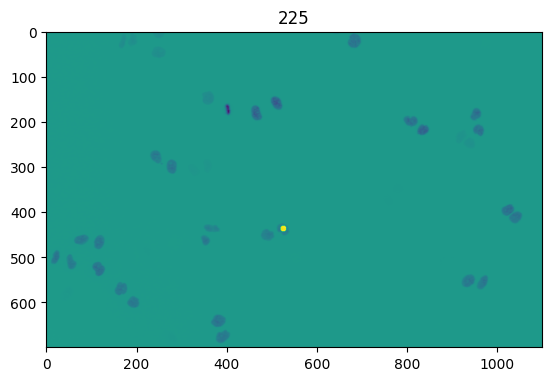

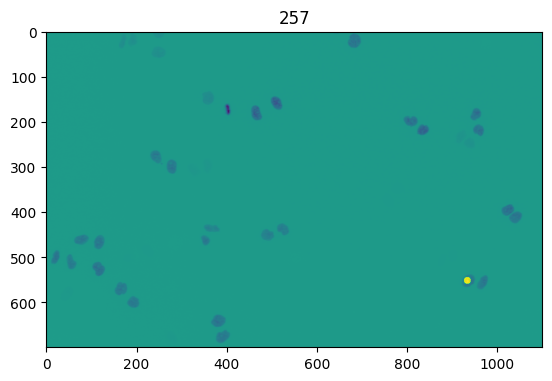

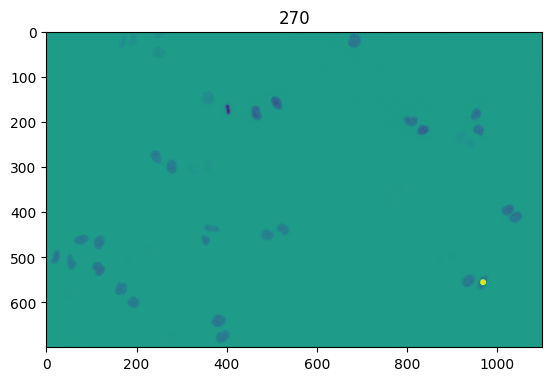

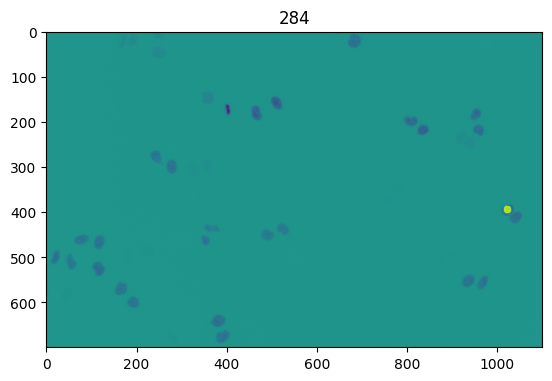

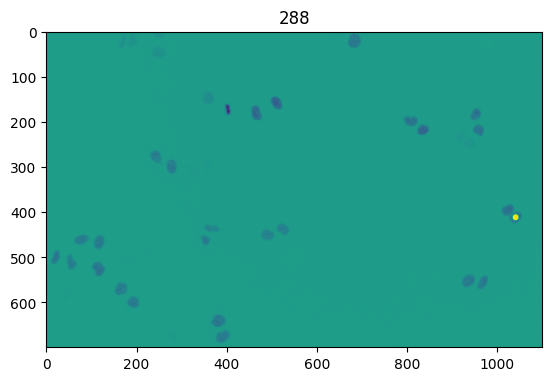

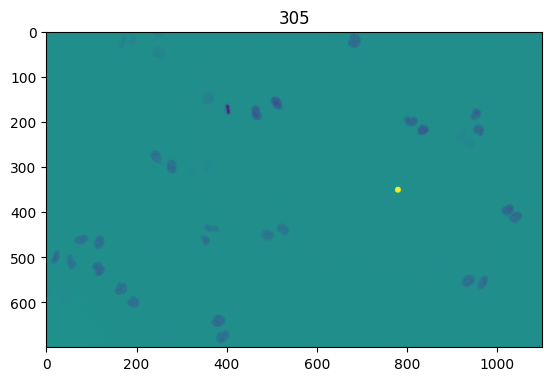

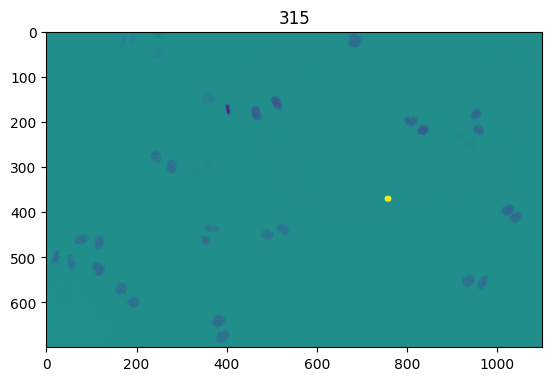

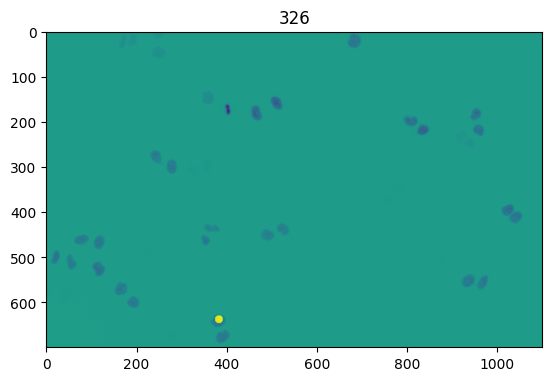

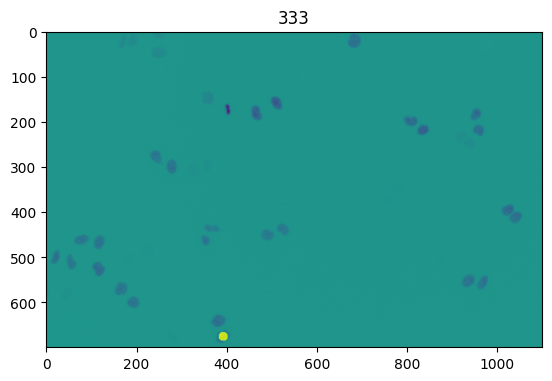

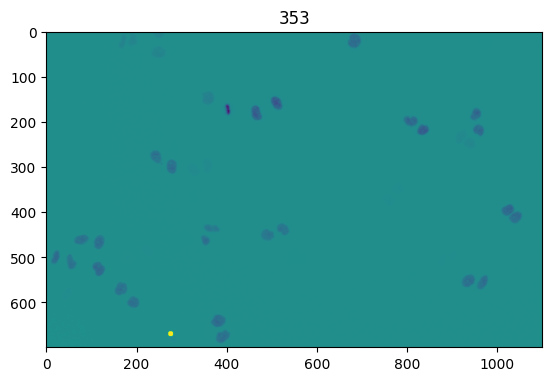

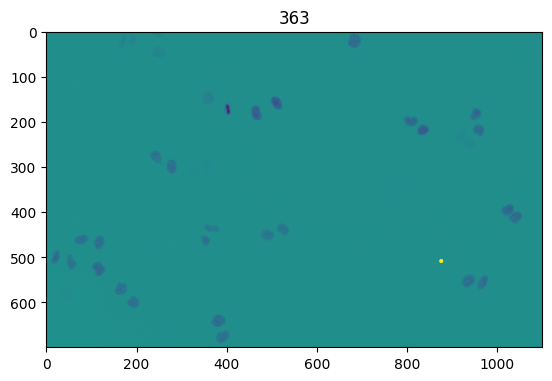

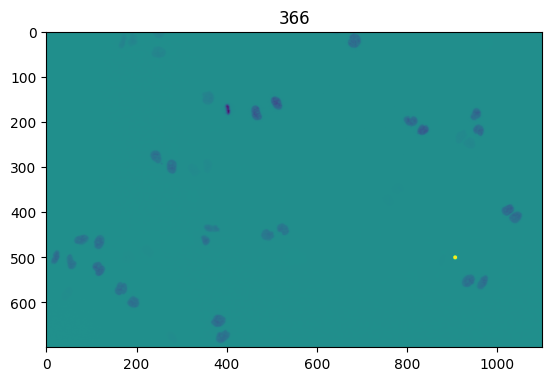

In [421]:
for i in np.unique(masks[1]):
    plt.title(i)
    plt.imshow(np.where(masks[1]==i,1,0)-images[1])

    plt.show()

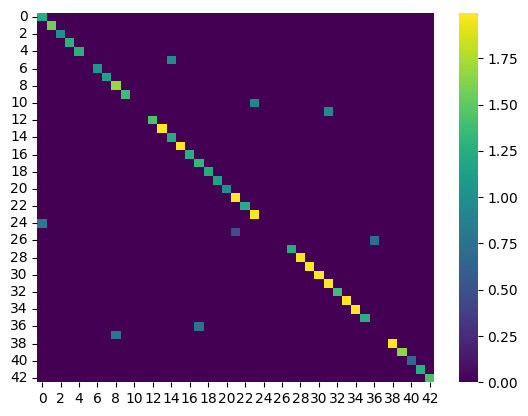

In [396]:
#take cosine_similarities_between_images and for each row get the index of the max value and only keep the value at that index and make all others 0s
max_indexes = []
for i in range(cosine_similarities_between_images_mean.shape[0]):
    max_indexes.append(np.argmax(cosine_similarities_between_images_mean[i]))
cosine_similarities_between_images_max = np.zeros(cosine_similarities_between_images_mean.shape)
for i in range(cosine_similarities_between_images_mean.shape[0]):
    cosine_similarities_between_images_max[i][max_indexes[i]] = cosine_similarities_between_images_mean[i][max_indexes[i]]
sns.heatmap(cosine_similarities_between_images_max, cmap='viridis'); plt.show()

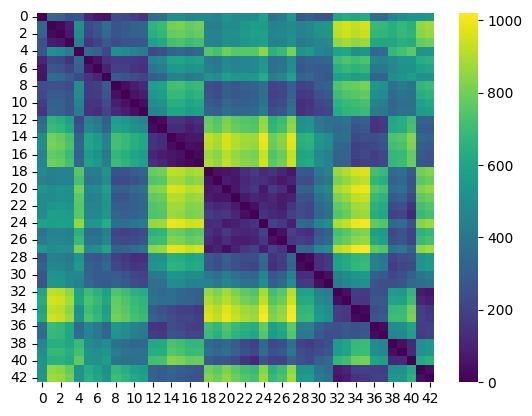

In [243]:
#get the centers of every cell in masks[0]
centers_0 = []
for i in np.unique(masks[0])[1:]:
    x, y = np.where(masks[0]==i)
    centers_0.append((np.mean(x),np.mean(y)))

#get the centers of every cell in masks[1]
centers_1 = []
for i in np.unique(masks[1])[1:]:
    x, y = np.where(masks[1]==i)
    centers_1.append((np.mean(x),np.mean(y)))

#calculate the distance between every pair of centers
distances = []
for i in range(len(centers_0)):
    distances_per_cell = []
    for j in range(len(centers_1)):
        distance = math.sqrt((centers_1[j][0]-centers_0[i][0])**2 + (centers_1[j][1]-centers_0[i][1])**2)
        distances_per_cell.append(math.sqrt((centers_1[j][0]-centers_0[i][0])**2 + (centers_1[j][1]-centers_0[i][1])**2))

    distances.append(distances_per_cell)
#heatmap plot of distances
sns.heatmap(np.array(distances), cmap='viridis'); plt.show()

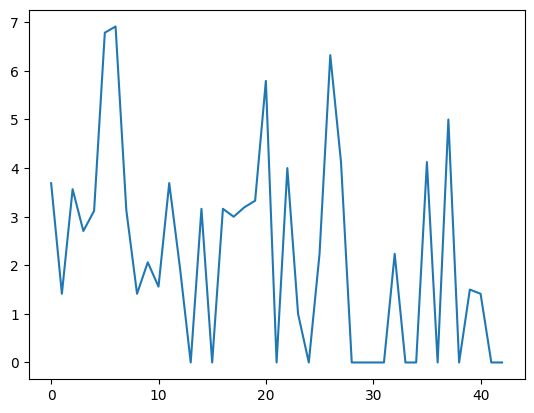

In [301]:
pairs_distances = [] #append the distances of the correct pairs
for i in range(len(distances)):
    pairs_distances.append(distances[i][i])
plt.plot(range(len(pairs_distances)), pairs_distances); plt.show()

In [233]:
print(distances[0][0])
print(distances[1][1])
print(distances[2][2])

0.1270064989009833
3.6885091466822897
nan


In [128]:
#Get the cosine similarity between the corresponding channels of encoding features between cells
#BONUS: display the grid

cos_sims_for_each_cell = []
for cell_encFeats in encodings_cells_per_channel_0:
    cos_sims_for_cell = []
    arr1 = cell_encFeats.flatten()
    for cell_encFeats2 in encodings_cells_per_channel_1:
        arr2 = cell_encFeats2.flatten()
        #if the length difference between arr1 and arr2 is over 25%, cos_sim == 0
        if abs(arr1.shape[0] - arr2.shape[0]) > 0.1 * max(arr1.shape[0], arr2.shape[0]):
            cos_sims_for_cell.append(0)
            continue

        #get the mean of each array
        #arr1_mean = np.mean(arr1)
        #arr2_mean = np.mean(arr2)
        #cos_sims_for_cell.append(abs(arr1_mean - arr2_mean)) #append the absolute value of the difference between the two means
        
    
        #pad the shorter array with the mean of the array
        print(arr1.shape, arr2.shape)
        if arr1.shape[0] > arr2.shape[0]:
            pad_by = arr1.shape[0]-arr2.shape[0]
            arr2 = np.pad(arr2, (0, pad_by), 'constant')
            #arr2 = np.pad(arr2, (0, arr1.shape[0] - arr2.shape[0]), 'mean')
            #arr1 = arr1[:arr2.shape[0]]
        elif arr1.shape[0] < arr2.shape[0]:
            arr2 = arr2[:arr1.shape[0]]
            #arr1 = np.pad(arr1, (0, arr2.shape[0] - arr1.shape[0]), 'mean')
            #arr2 = arr2[:arr1.shape[0]]
        cos_sim = np.dot(arr1, arr2) / (np.linalg.norm(arr1) * np.linalg.norm(arr2))
        cos_sims_for_cell.append(cos_sim)

    cos_sims_for_each_cell.append(cos_sims_for_cell)

cos_sims_for_each_cell = np.array(cos_sims_for_each_cell)

lst = cos_sims_for_each_cell.tolist()


#Average out the cosine similarity to get a single number between every cell between two images

(64,) (64,)


ValueError: operands could not be broadcast together with shapes (34,) (29,) 

In [ ]:
#Use the grid algorithm to match the cells between the two images

In [ ]:
#Compare the found indices to the groundtruth indices